In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from datetime import datetime, timedelta

from configs.base_config import TrainingModuleConfig
from configs.base_config import ModelEvaluatorConfig

from modules.data_fetcher_module import DataFetcherModule
from modules.forecasting_module import ForecastingModule
from configs.base_config import ForecastingModuleConfig
from modules.model_evaluator import ModelEvaluator
from modules.training_module import TrainingModule

In [2]:
with open('train_config.json') as f_train, \
    open('test_config.json') as f_test, \
    open('forecast_config.json') as f_forecast:
    default_train_config = json.load(f_train)
    default_test_config = json.load(f_test)
    default_forecast_config = json.load(f_forecast)

In [3]:
def parse_params(parameters, interval='Train1'):
    """
        Flatten the params dictionary to enable logging
    of the parameters.
    
    Assumptions:
        There is a maximum of one level of nesting.
        Ensured using an assert statement for now.
        
    Sample_input:
        {
            'LatentEbyCRatio': {
                '4/7/20': 0.5648337712691847,
                '4/17/20': 1.1427545912005197
            },
            'LatentIbyCRatio': {
                '4/7/20': 0.9610881623714099,
                '4/17/20': 0.6742970940209254
            }
        }
    
    Output:
        {
            'Train1_LatentEbyCRatio_4/7/20': 0.5648337712691847,
            'Train1_LatentEbyCRatio_4/17/20': 1.1427545912005197,
            'Train1_LatentIbyCRatio_4/7/20': 0.9610881623714099,
            'Train1_LatentIbyCRatio_4/17/20': 0.6742970940209254
        }
    """
    param_dict = dict() # The flattened dictionary to return
    for param in parameters:
        if isinstance(parameters[param], dict):
            for key in parameters[param]:
                assert (not isinstance(parameters[param][key], dict))
                
                param_dict[interval + '_' + param + '_'+ key] = parameters[param][key]
        else:
            param_dict[interval + '_' + param] = parameters[param]
    return param_dict

In [4]:
def train_eval(region, region_type, 
               train1_start_date, train1_end_date, 
               train2_start_date, train2_end_date, run_day,
               test_start_date, test_end_date, max_evals = 1000, 
               data_source = None, mlflow_log = True, name_prefix = None):
    """
        #TODO: Need to add hooks to consume data from appropriate source

        Run train and evalation for (basic) SEIR model.
    
    Arguments:
        region, region_type : Region info corresponding to the run
        train1_start_date, train1_end_date : Train1 durations
        train2_start_date, train2_end_date : Train2 durations
        test_start_date, test_end_date, run_day : Test durations
        max_evals : number of search evaluations for SEIR (default: 1000)
        data_source : Data source for picking the region data
        mlflow_log : Experiment logged using MLFlow (default: True)
        name_prefix : In case of non-MLFlow experiment, string prefix to
                      enable easy indexing of experiments

    Note:
        date_format : %-m/%-d/%-y

    Returns: 
        params : Run parameters to be logged
        metrics : Metrics collected from the run 
    
    Output files saved : (name_prefix added in the case of non-MLflow experiments)
        Train1 : train1_output.json (name_prefix + '_train1_output.json')
        Train2 : train2_output.json (name_prefix + '_train2_output.json')
        Test   : test_output.json   (name_prefix + '_test_output.json')
    """
    
    # Save metrics and params for logging
    params = dict()
    metrics = dict()

    params['region'] = region
    params['region_type'] = region_type
    params['train1_start_date'] = train1_start_date
    params['train1_end_date'] = train1_end_date
    params['train2_start_date'] = train2_start_date
    params['train2_end_date'] = train2_end_date
    params['run_day'] = run_day
    params['test_start_date'] = test_start_date
    params['test_end_date'] = test_end_date
    params['data_source'] = data_source
    
    # model parameters
    model_params = dict()
    model_params['region'] = region
    model_params['region_type'] = region_type
    model_params['model_type'] = "SEIR"
    

    train_config = deepcopy(default_train_config)
    train_config['region_name'] = region
    train_config['region_type'] = region_type
    train_config['train_start_date'] = train1_start_date
    train_config['train_end_date'] = train1_end_date
    train_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        train_config['output_filepath'] = 'train1_output.json'
    else:
        assert name_prefix is not None
        train_config['output_filepath'] = name_prefix + '_train1_output.json'

    train_module_config = TrainingModuleConfig.parse_obj(train_config)
    trainResults = TrainingModule.from_config(train_module_config)
    
    metrics['Train1MAPE'] = trainResults['train_metric_results'][0]['value']
    metrics['Train1RMLSE'] = trainResults['train_metric_results'][1]['value']
    metrics.update(parse_params(trainResults['best_params'], 'Train1'))
    metrics.update(parse_params(trainResults['latent_params'], 'Train1')) 
    
    test_config = deepcopy(default_test_config)
    test_config['region_name'] = region
    test_config['region_type'] = region_type
    test_config['test_start_date'] = test_start_date
    test_config['test_end_date'] = test_end_date
    test_config['run_day'] = run_day
    test_config['model_parameters'].update(trainResults['best_params'])    
    test_config['model_parameters'].update(trainResults['latent_params'])  
        
    if mlflow_log:
        test_config['output_filepath'] = 'test_output.json'
    else:
        test_config['output_filepath'] = name_prefix + '_test_output.json'

    test_module_config = ModelEvaluatorConfig.parse_obj(test_config) 
    evalResults = ModelEvaluator.from_config(test_module_config)
    
    metrics['TestMAPE'] = evalResults[0]['value']
    metrics['TestRMLSE'] = evalResults[1]['value']
    
    
    finalTrain_config = deepcopy(default_train_config)
    finalTrain_config['region_name'] = region
    finalTrain_config['region_type'] = region_type
    finalTrain_config['train_start_date'] = train2_start_date
    finalTrain_config['train_end_date'] = train2_end_date
    finalTrain_config['search_parameters']['max_evals'] = max_evals
    
    if mlflow_log:
        finalTrain_config['output_filepath'] = 'train2_output.json'
    else:
        finalTrain_config['output_filepath'] = name_prefix + '_train2_output.json'

    finalTrain_module_config = TrainingModuleConfig.parse_obj(finalTrain_config)
    finalResults = TrainingModule.from_config(finalTrain_module_config)
    
    metrics['Train2MAPE'] = finalResults['train_metric_results'][0]['value']
    metrics['Train2RMLSE'] = finalResults['train_metric_results'][1]['value']
    metrics.update(parse_params(finalResults['best_params'], 'Train2'))
    metrics.update(parse_params(finalResults['latent_params'], 'Train2'))
        
    model_params['model_parameters'] = dict()
    model_params['model_parameters'].update(finalResults['best_params'])
    model_params['model_parameters'].update(finalResults['latent_params'])
    model_params['model_parameters']['MAPE'] = finalResults['train_metric_results'][0]['value']
    
    return params, metrics, model_params

In [ ]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
run_day = '4/17/20'

params, metrics, model_params = train_eval(region, region_type, 
                                           train1_start_date, train1_end_date, 
                                           train2_start_date, train2_end_date, run_day,
                                           test_start_date, test_end_date,
                                           max_evals = 100,
                                           mlflow_log = False,
                                           name_prefix = 'mumbai_sample')

In [6]:
params

{'region': 'mumbai',
 'region_type': 'district',
 'train1_start_date': '4/8/20',
 'train1_end_date': '4/17/20',
 'train2_start_date': '4/13/20',
 'train2_end_date': '4/22/20',
 'run_day': '4/17/20',
 'test_start_date': '4/18/20',
 'test_end_date': '4/22/20',
 'data_source': None}

In [7]:
metrics

{'Train1MAPE': 11.578174165264489,
 'Train1RMLSE': 0.16116568154195587,
 'Train1_EbyCRatio': 0.997846723858413,
 'Train1_IbyCRatio': 0.9649266645632104,
 'Train1_infectious_period': 1.972849036575382,
 'Train1_r0': 1.2069689962408814,
 'Train1_LatentEbyCRatio_4/7/20': 0.997846723858413,
 'Train1_LatentEbyCRatio_4/17/20': 0.20183231784791927,
 'Train1_LatentIbyCRatio_4/7/20': 0.9649266645632104,
 'Train1_LatentIbyCRatio_4/17/20': 0.0962324511801066,
 'TestMAPE': 5.029744756579331,
 'TestRMLSE': 0.05993902610780722,
 'Train2MAPE': 8.768146390596282,
 'Train2RMLSE': 0.09560677914187868,
 'Train2_EbyCRatio': 0.5369542220931649,
 'Train2_IbyCRatio': 0.877531106686125,
 'Train2_infectious_period': 5.031419911631426,
 'Train2_r0': 0.5169788535587769,
 'Train2_LatentEbyCRatio_4/12/20': 0.5369542220931649,
 'Train2_LatentEbyCRatio_4/22/20': 0.1780890696175734,
 'Train2_LatentIbyCRatio_4/12/20': 0.877531106686125,
 'Train2_LatentIbyCRatio_4/22/20': 0.2511722686138453}

In [8]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5369542220931649,
  'IbyCRatio': 0.877531106686125,
  'infectious_period': 5.031419911631426,
  'r0': 0.5169788535587769,
  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
   '4/22/20': 0.1780890696175734},
  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
   '4/22/20': 0.2511722686138453},
  'MAPE': 8.768146390596282}}

In [9]:
model_params['model_parameters']['incubation_period'] = 5

In [10]:
model_params

{'region': 'mumbai',
 'region_type': 'district',
 'model_type': 'SEIR',
 'model_parameters': {'EbyCRatio': 0.5369542220931649,
  'IbyCRatio': 0.877531106686125,
  'infectious_period': 5.031419911631426,
  'r0': 0.5169788535587769,
  'LatentEbyCRatio': {'4/12/20': 0.5369542220931649,
   '4/22/20': 0.1780890696175734},
  'LatentIbyCRatio': {'4/12/20': 0.877531106686125,
   '4/22/20': 0.2511722686138453},
  'MAPE': 8.768146390596282,
  'incubation_period': 5}}

In [27]:
def forecast(model_params, run_day, forecast_start_date, forecast_end_date):
    evalConfig = ForecastingModuleConfig.parse_obj(default_forecast_config)
    evalConfig.region_name = model_params['region']
    evalConfig.region_type = model_params['region_type']
    evalConfig.model_parameters = model_params['model_parameters']

    evalConfig.run_day = run_day
    evalConfig.forecast_start_date = forecast_start_date
    evalConfig.forecast_end_date = forecast_end_date
    
    forecast_json = ForecastingModule.from_config(evalConfig)
    forecast_df = pd.read_json(forecast_json)
    forecast_df = forecast_df.drop(columns=['Region Type', 'Region', 'Country', 'Lat', 'Long'])
    forecast_df = forecast_df.set_index('prediction_type')
    forecast_df = forecast_df.transpose().reset_index()
    return forecast_df

In [28]:
run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)

t = 10.90


In [29]:
forecast_df

prediction_type,index,exposed,active_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max
0,4/13/20,672.545698,1057.797514,366.339510,9.779083,1433.916107,275.027354,965.048280,1150.546749,250.912553,299.142155,334.218325,398.460694,8.921639,10.636528,1308.188244,1559.643971
1,4/14/20,646.415522,986.445478,564.222070,15.061369,1565.728917,256.475824,899.952494,1072.938461,233.987649,278.964000,514.750253,613.693887,13.740766,16.381972,1428.443513,1703.014320
2,4/15/20,618.884816,922.845890,749.209809,19.999440,1692.055139,239.939931,841.929412,1003.762369,218.901647,260.978216,683.517996,814.901621,18.245860,21.753021,1543.693268,1840.417011
3,4/16/20,590.385846,866.086903,922.276404,24.619288,1812.982595,225.182595,790.147136,942.026671,205.438255,244.926934,841.409859,1003.142949,22.460633,26.777943,1654.017627,1971.947563
4,4/17/20,561.618168,814.902213,1084.572449,28.951626,1928.426287,211.874575,743.450394,886.354032,193.297102,230.452048,989.475549,1179.669349,26.413105,31.490147,1759.339047,2097.513527
5,4/18/20,533.577072,767.631590,1237.447830,33.032488,2038.111908,199.584213,700.324528,834.938651,182.084377,217.084049,1128.946593,1345.949067,30.136151,35.928825,1859.407272,2216.816544
6,4/19/20,506.693572,723.411670,1381.780271,36.885305,2142.077246,188.087034,659.981876,786.841464,171.595288,204.578781,1260.623754,1502.936788,33.651147,40.119463,1954.256778,2329.897715
7,4/20/20,480.696852,682.366976,1517.866821,40.518005,2240.751803,177.415414,622.536041,742.197911,161.859371,192.971457,1384.778036,1650.955606,36.965327,44.070684,2044.279405,2437.224201
8,4/21/20,455.610497,644.227332,1646.208102,43.943953,2334.379388,167.499106,587.740537,700.714128,152.812540,182.185673,1501.866166,1790.550038,40.090883,47.797024,2129.697586,2539.061190
9,4/22/20,431.535745,608.626977,1767.341138,47.177484,2423.145599,158.243014,555.261673,661.992282,144.368035,172.117993,1612.378079,1922.304196,43.040893,51.314075,2210.680646,2635.610552


In [14]:
def get_observations_in_range(region_name, region_type, 
                              start_date, end_date,
                              obs_type = 'confirmed'):
    """
        Return a list of counts of obs_type cases
        from the region in the specified date range.
    """
    observations = DataFetcherModule.get_observations_for_region(region_type, region_name)
    observations_df = observations[observations['observation'] == obs_type]
    
    start_date = datetime.strptime(start_date, '%m/%d/%y')
    end_date = datetime.strptime(end_date, '%m/%d/%y')
    delta = (end_date - start_date).days
    days = []
    for i in range(delta + 1):
        days.append((start_date + timedelta(days=i)).strftime('%-m/%-d/%-y'))
    
    # Fetch observations in the date range
    observations_df = observations_df[days]
    
    # Transpose the df to get the
    # observations_df.shape = (num_days, 1)
    observations_df = observations_df.reset_index(drop=True).transpose()
    
    # Rename the column to capture observation type
    # Note that the hardcoded 0 in the rename comes from the reset_index
    # from the previous step
    observations = observations_df[0].to_list()
    return observations

In [15]:
observations = get_observations_in_range('mumbai', 'district', '4/13/20', '4/22/20')

In [30]:
forecast_df['actual_confirmed'] = observations

In [31]:
forecast_df

prediction_type,index,exposed,active_mean,recovered_mean,deceased_mean,confirmed_mean,hospitalized_mean,active_min,active_max,hospitalized_min,hospitalized_max,recovered_min,recovered_max,deceased_min,deceased_max,confirmed_min,confirmed_max,actual_confirmed
0,4/13/20,672.545698,1057.797514,366.339510,9.779083,1433.916107,275.027354,965.048280,1150.546749,250.912553,299.142155,334.218325,398.460694,8.921639,10.636528,1308.188244,1559.643971,1540.0
1,4/14/20,646.415522,986.445478,564.222070,15.061369,1565.728917,256.475824,899.952494,1072.938461,233.987649,278.964000,514.750253,613.693887,13.740766,16.381972,1428.443513,1703.014320,1756.0
2,4/15/20,618.884816,922.845890,749.209809,19.999440,1692.055139,239.939931,841.929412,1003.762369,218.901647,260.978216,683.517996,814.901621,18.245860,21.753021,1543.693268,1840.417011,1896.0
3,4/16/20,590.385846,866.086903,922.276404,24.619288,1812.982595,225.182595,790.147136,942.026671,205.438255,244.926934,841.409859,1003.142949,22.460633,26.777943,1654.017627,1971.947563,2073.0
4,4/17/20,561.618168,814.902213,1084.572449,28.951626,1928.426287,211.874575,743.450394,886.354032,193.297102,230.452048,989.475549,1179.669349,26.413105,31.490147,1759.339047,2097.513527,2085.0
5,4/18/20,533.577072,767.631590,1237.447830,33.032488,2038.111908,199.584213,700.324528,834.938651,182.084377,217.084049,1128.946593,1345.949067,30.136151,35.928825,1859.407272,2216.816544,2268.0
6,4/19/20,506.693572,723.411670,1381.780271,36.885305,2142.077246,188.087034,659.981876,786.841464,171.595288,204.578781,1260.623754,1502.936788,33.651147,40.119463,1954.256778,2329.897715,2268.0
7,4/20/20,480.696852,682.366976,1517.866821,40.518005,2240.751803,177.415414,622.536041,742.197911,161.859371,192.971457,1384.778036,1650.955606,36.965327,44.070684,2044.279405,2437.224201,2455.0
8,4/21/20,455.610497,644.227332,1646.208102,43.943953,2334.379388,167.499106,587.740537,700.714128,152.812540,182.185673,1501.866166,1790.550038,40.090883,47.797024,2129.697586,2539.061190,2455.0
9,4/22/20,431.535745,608.626977,1767.341138,47.177484,2423.145599,158.243014,555.261673,661.992282,144.368035,172.117993,1612.378079,1922.304196,43.040893,51.314075,2210.680646,2635.610552,2687.0


In [32]:
def plot(model_params, forecast_df, forecast_start_date, forecast_end_date, plot_name = 'default.png'):
    """
        Plot actual_confirmed cases vs forecasts.
        
        Assert that forecast_end_date is prior to the current date
        to ensure availability of actual_counts.
    """
    # Check for forecast_end_date being prior to current date
    end_date = datetime.strptime(forecast_end_date, '%m/%d/%y')
    assert end_date < datetime.now()    
    
    # Fetch actual counts from the DataFetcher module
    region_name = model_params['region']
    region_type = model_params['region_type']
    actual_observations = DataFetcherModule.get_observations_for_region(region, region_type)
    
    # Get relevant time-series of actual counts from actual_observations
    actual_observations = get_observations_in_range(region_name, region_type, 
                                                    forecast_start_date, 
                                                    forecast_end_date,
                                                    obs_type = 'confirmed')
    
    forecast_df['actual_confirmed'] = actual_observations
    
    fig, ax = plt.subplots(figsize=(15, 5))
    fig.suptitle(model_params['region'])
    ax.plot(forecast_df['index'], forecast_df['actual_confirmed'], color='blue', label="actual_confirmed")
    ax.plot(forecast_df['index'], forecast_df['confirmed_mean'], color='orange', label="predicted_confirmed")
    ax.set_ylim(ymin=0)
    ax.legend()

    plt.savefig(plot_name)

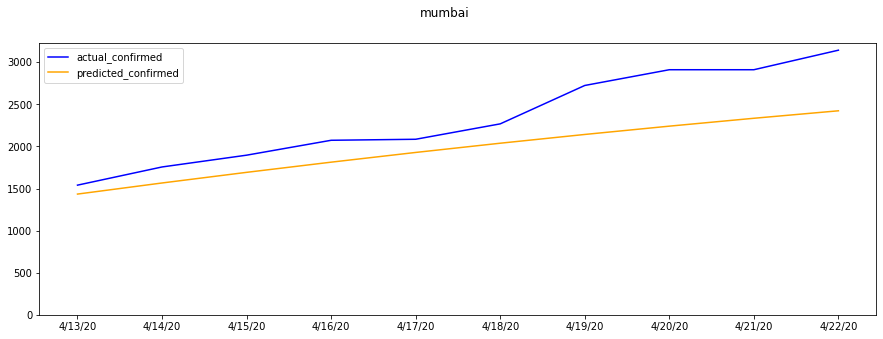

In [33]:
plot(model_params, forecast_df, forecast_start_date, forecast_end_date)

In [37]:
def train_eval_forecast(region, region_type, 
                        train1_start_date, train1_end_date, 
                        train2_start_date, train2_end_date,
                        test_run_day, test_start_date, test_end_date, 
                        forecast_run_day, forecast_start_date, forecast_end_date,
                        max_evals = 1000, 
                        data_source = None, mlflow_log = True, name_prefix = None,
                        plot_actual_vs_predicted = False, plot_name = 'default.png'):
    """
        Run train, evaluation and generate forecasts as a dataframe.
        
        If plot_actual_vs_predicted is set to True,
        we first check if the forecast_end_date is prior to the current date
        so that we have actual_confirmed cases and then plot the predictions.
    """
    params, metrics, model_params = train_eval(region, region_type, 
                                               train1_start_date, train1_end_date, 
                                               train2_start_date, train2_end_date, 
                                               test_run_day, test_start_date, test_end_date, 
                                               max_evals, data_source, 
                                               mlflow_log, name_prefix)
    model_params['model_parameters']['incubation_period'] = 5
    forecast_df = forecast(model_params, run_day, forecast_start_date, forecast_end_date)
    
    if plot_actual_vs_predicted:
        # Check for forecast_end_date being prior to current date
        end_date = datetime.strptime(forecast_end_date, '%m/%d/%y')
        assert end_date < datetime.now()

        plot(model_params, forecast_df, forecast_start_date, forecast_end_date, plot_name)
    return forecast_df, params, metrics, model_params

In [ ]:
region = 'mumbai'
region_type = 'district'
train1_start_date = '4/8/20'
train1_end_date = '4/17/20'
train2_start_date = '4/13/20'
train2_end_date = '4/22/20'
test_start_date = '4/18/20'
test_end_date = '4/22/20'
test_run_day = '4/17/20'
forecast_run_day = '4/12/20'
forecast_start_date = '4/13/20'
forecast_end_date = '4/22/20'
name_prefix = 'mumbai_sample'

train_eval_forecast(region, region_type, 
                    train1_start_date, train1_end_date, 
                    train2_start_date, train2_end_date,
                    test_run_day, test_start_date, test_end_date, 
                    forecast_run_day, forecast_start_date, forecast_end_date,
                    max_evals = 10, 
                    mlflow_log = False, name_prefix = name_prefix,
                    plot_actual_vs_predicted = 'True',
                    plot_name = 'default.png')

t = 10.90                                             
t = 10.90                                             
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                       
t = 10.90                                                                      
t = 10.90                                                                      
t = 10.90                                                                      
100%|██████████| 10/10 [00:00<00:00, 19.21trial/s, best loss: 560.0495269601387]
Best fit: {'EbyCRatio': 12.623794878231601, 'IbyCRatio': 0.8032371249857521, 'infectious_period': 8.984487322865482, 'r0': 2.541260653405924}
Best Loss: 560.0495269